Source: https://hackernoon.com/using-gans-to-create-anime-faces-via-pytorch-s17i3uug

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch 
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.utils as vutils
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML, Image
# from google.colab import files

# Getting the Data

! pip install -q kaggle

! kaggle datasets download 'splcher/animefacedataset'

# Data Preprocessing and Visualization

In [ ]:
# Root directory for dataset
dataroot = "Datasets/anime_images"
#number of workers for dataloader
workers = 2

#batch size during training
batch_size = 128

#spatial size of training images. all trainin gimagse will be resized to this
image_size=64

#number of color channels
color_channels = 3

#size of z latent vector
nz=100

#Size of feature maps in generator
ngf=64

#Size of feature maps in discriminator
ndf=64

#Number of training epochs
num_epochs=50

#learning rate
lr=0.0002

#Beta1 hyperparam for Adam optimizers
beta1=0.5

#Number of GPUs available. Use 0 for CPU mode
ngpu=0

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

In [ ]:
# create dataloader
dataloader  = torch.utils.data.DataLoader( dataset, batch_size = batch_size, shuffle=True, num_workers=workers)

In [ ]:
# Device type to run on
device = torch.device( "cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

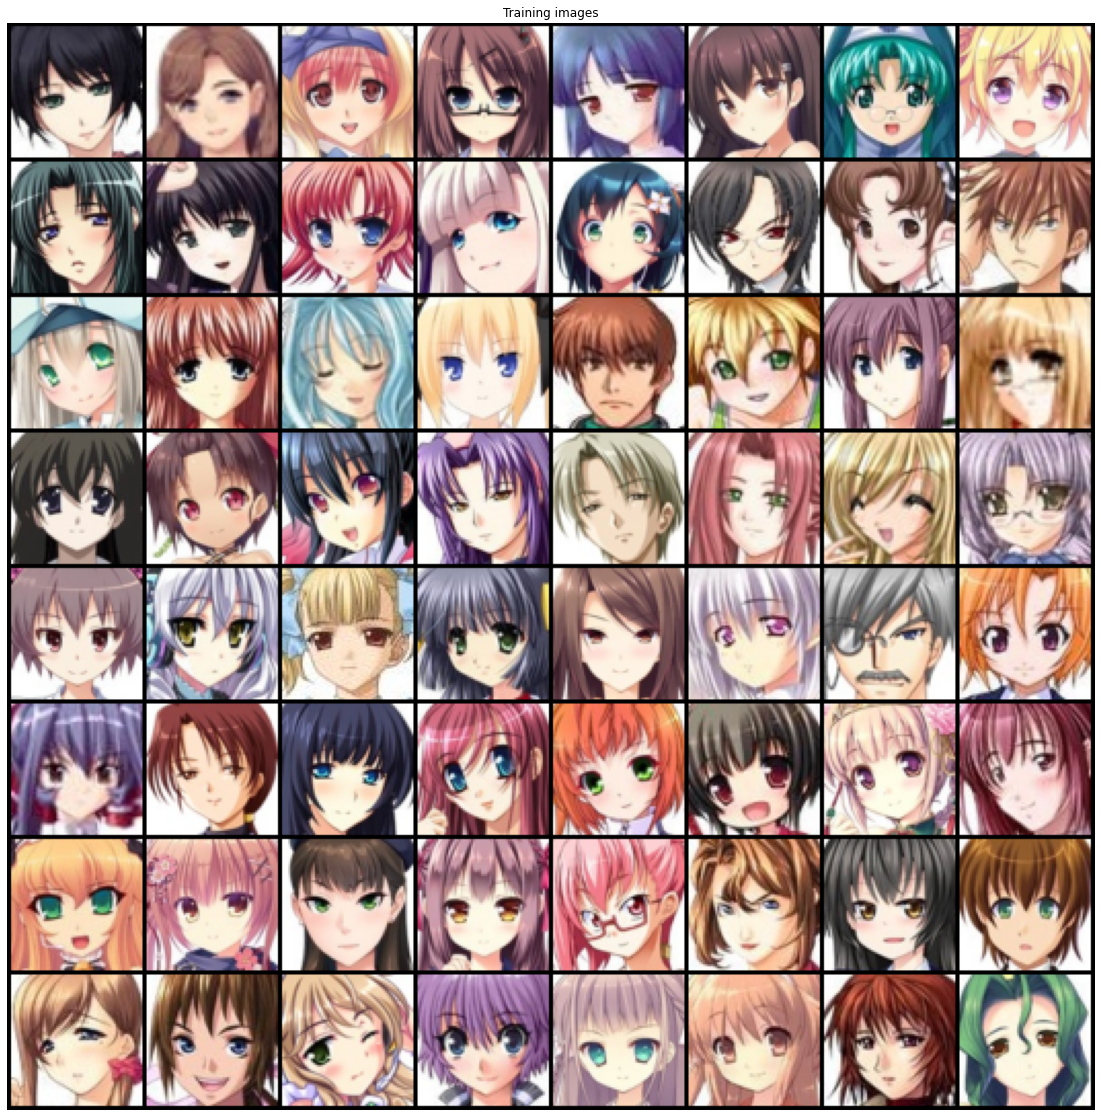

In [ ]:
# plot some training images
real_batch = next( iter( dataloader))
plt.figure( figsize=(20,20))
plt.axis("off")
plt.title("Training images")
plt.imshow( np.transpose( vutils.make_grid( real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is noise, going into a convolution
            # Transpose 2D conv layer 1. 
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Resulting state size - (ngf*8) x 4 x 4 i.e. if ngf= 64 the size is 512 maps of 4x4 
            
            # Transpose 2D conv layer 2.
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Resulting state size -(ngf*4) x 8 x 8 i.e 8x8 maps
            
            # Transpose 2D conv layer 3.
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Resulting state size. (ngf*2) x 16 x 16
            
            # Transpose 2D conv layer 4.
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Resulting state size. (ngf) x 32 x 32
            
            # Final Transpose 2D conv layer 5 to generate final image. 
            # nc is number of channels - 3 for 3 image channel
            nn.ConvTranspose2d( ngf, color_channels, 4, 2, 1, bias=False),
            
            # Tanh activation to get final normalized image
            nn.Tanh()
            # Resulting state size. (nc) x 64 x 64
        )

    def forward(self, input):
        ''' This function takes as input the noise vector'''
        return self.main(input)

In [ ]:
# Generator Network
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu=ngpu
    self.network = nn.Sequential(
        #Conv layer 1
        nn.Conv2d(color_channels, ndf, 4,2,1,bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        #Conv Layer 2
        nn.Conv2d( ndf, ndf*2, 4, 2,1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),

        #Conv Layer 3
        nn.Conv2d( ndf*2, ndf*4, 4,2,1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),

        #Conv layer 4
        nn.Conv2d(ndf*4, ndf*8, 4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),

        #Conv layer 5
        nn.Conv2d(ndf*8, 1, 4,1,0,bias=False),

        nn.Sigmoid()
    )
  def forward(self, input):
    return self.network(input)

In [ ]:
#Create the Discriminator Network
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the model
print(netD)

Discriminator(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#Loss Criterion and Optimizers

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1,1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam( netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam( netG.parameters(), lr=lr, betas=(beta1,0.999))

# Training Loop

# Results

# Saving the model

In [ ]:
torch.save(netG, 'generator.pth')
torch.save(netD, 'discriminator.pth')

In [ ]:
files.download('generator.pth')
files.download('discriminator.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load the Model

In [ ]:
state_dict = torch.load('./Models/generator.pth', map_location=device).state_dict()
netG.load_state_dict(state_dict)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


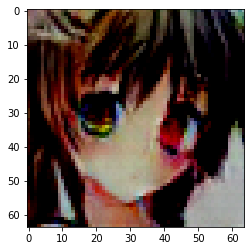

In [ ]:
torch.manual_seed(np.random.random()*10000)
noise = torch.randn(1, nz, 1,1, device=device)
fake = netG(noise)
plt.imshow( np.transpose(fake[0].detach().cpu(),(1,2,0)))
# plt.imshow( np.transpose( vutils.make_grid( real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))